In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols

In [2]:
# VC_protocol = vc_protocols.hERG_CiPA()
# VC_protocol = vc_protocols.cav12_CiPA()
# VC_protocol = vc_protocols.lateNav15_CiPA()

In [3]:
'''
SongV1
'''
VC_protocol = protocol_lib.VoltageClampProtocol()  # steps=steps

VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-120, duration=20) ) 
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-40, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=60, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=200) )  # <- why?? vo
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=50, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-10, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=50) )
VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=30, voltage_end=-50, duration=100)) # ramp step

vhold = -80

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} ms')

The protocol is 1270 ms


In [4]:
'''
leemV1
'''
VC_protocol = protocol_lib.VoltageClampProtocol()  # steps=steps
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-90, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-35, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-40, duration=40) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=40) )  
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=40, duration=500) )
VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=40, voltage_end=-120, duration=200)) # ramp step

# settings

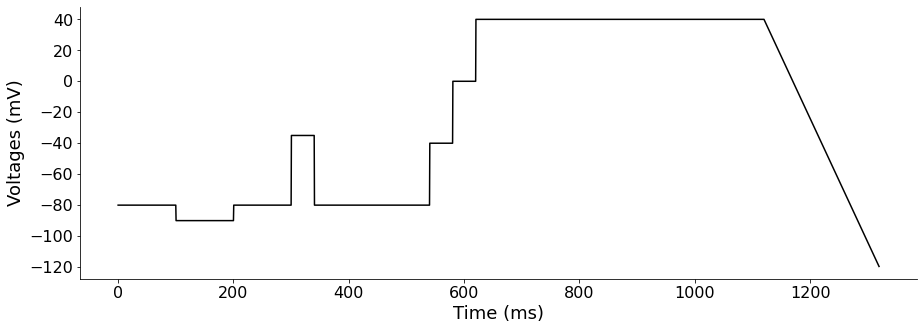

In [5]:
times = np.arange(0, VC_protocol.get_voltage_change_endpoints()[-1], 0.5) 
VC_protocol.plot_voltage_clamp_protocol(times)

In [6]:
end_time = VC_protocol.get_voltage_change_endpoints()[-1]
bcl = 1000
duration = 0.5
offset = 20
window = 10
step_size = 5

cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
extra_log=['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ical.ICaNa', 'ical.ICaK', 'ikr.IKr', 'iks.IKs', 'ik1.IK1', 'inaca.INaCa', 'inacass.INaCa_ss', 'inak.INaK', 'ikb.IKb', 'inab.INab', 'icab.ICab', 'ipca.IpCa']

t_span = (0, end_time)
t_eval = np.linspace(0, t_span[1], 10000)  

In [7]:
start_time = time.time()

model, p, s = myokit.load("../mmt-model-files/ohara-cipa-v1-2017_JK-v1.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=vhold)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "ohara2017"  
f = 1.5
params = {         
    'cell.mode': cell_types['Mid-myocardial'],
    'setting.simType': 1,   # 0: AP   |  1: VC  
    
    'ina.gNa' : 75.0 * f,   
    'inal.gNaL' : 0.0075 * 2.661 * f,  
    'ito.gto' : 0.02 * 4 * f,
    'ical.PCa' : 0.0001 * 1.007 * 2.5 * f,
    'ikr.gKr' : 4.65854545454545618e-2 * 1.3 * f, # [mS/uF]
    'iks.gKs' : 0.0034 * 1.87 * 1.4 * f,
    'ik1.gK1' : 0.1908 * 1.698 * 1.3 * f,
    'inaca.gNaCa' : 0.0008 * 1.4,
    'inak.PNaK' : 30 * 0.7,
    'ikb.gKb' : 0.003,
    'inab.PNab' : 3.75e-10,
    'icab.PCab' : 2.5e-8,
    'ipca.GpCa' : 0.0005,
    
    'ina.g_adj' : 1,  
    'inal.g_adj' : 1,
    'ito.g_adj' : 1,
    'ical.g_adj' : 1,
    'ikr.g_adj' : 1,
    'iks.g_adj' : 1,
    'ik1.g_adj' : 1,
    'inaca.g_adj' : 1,
    'inak.g_adj' : 1,
    'ikb.g_adj' : 1,
    'inab.g_adj' : 1,
    'icab.g_adj' : 1,
    'ipca.g_adj' : 1, 
}
sim.set_simulation_params(params)
y0 = sim.pre_simulate(5000, sim_type=1)
d = sim.simulate(end_time, log_times=None, extra_log=['membrane.i_ion'] + extra_log)

sol1 = {}
times1 = d['engine.time']
sol1["Voltage"] = VC_protocol.get_voltage_clamp_protocol(d['engine.time'])
sol1["I_total"] = d['membrane.i_ion']
sol1["INa"] = d['ina.INa']
sol1["INaL"] = d['inal.INaL']
sol1["Ito"] = d['ito.Ito']
sol1["ICaL"] = d['ical.ICaL']
sol1["IKr"] = d['ikr.IKr']
sol1["IKs"] = d['iks.IKs']
sol1["IK1"] = d['ik1.IK1']

tr = mod_trace.Trace(VC_protocol,
                     cell_params=None,
                     t=times1,
                     y=sol1["Voltage"],  # simulator.model.V,
                     command_voltages=sol1["Voltage"],
                     current_response_info=sim.current_response_info,
                     default_unit=None)   
max_contributions1 = tr.current_response_info.get_max_current_contributions(time=times1,
                                                                           window=window,
                                                                           step_size=step_size)

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.9580655097961426 seconds ---


In [8]:
max_contributions1

,Current,Contribution,Time Start,Time End
0,i_ion,0.000000,0.0,10.0
1,INa,0.396718,540.0,550.0
2,INaL,0.334386,565.0,575.0
3,Ito,0.171660,625.0,635.0
4,ICaL,0.430098,585.0,595.0
5,ICaNa,0.084078,620.0,630.0
6,ICaK,0.142714,620.0,630.0
7,IKr,0.363745,1200.0,1210.0
8,IKs,0.210319,1115.0,1125.0
9,IK1,0.495002,1310.0,1320.0


In [ ]:
print( targets[bad_index])
[0.91128737 0.33829537 0.8478293  0.13588126 0.09051295 0.8697364
 0.01044093]

print( final_results[bad_index])
[0.8389102  0.35914838 0.8480872  0.1362117  0.08961055 0.86768395
 0.01095095]

In [12]:
start_time = time.time()

params = {         
    'cell.mode': cell_types['Mid-myocardial'],
    'setting.simType': 1,   # 0: AP   |  1: VC  

    'ina.g_adj' : 0.8389102,  
    'inal.g_adj' : 0.35914838,
    'ito.g_adj' : 0.8480872,
    'ical.g_adj' : 0.1362117,
    'ikr.g_adj' : 0.08961055,
    'iks.g_adj' : 0.86768395,
    'ik1.g_adj' : 0.01095095,
    # 'inaca.g_adj' : 1,
    # 'inak.g_adj' : 1,
    # 'ikb.g_adj' : 1,
    # 'inab.g_adj' : 1,
    # 'icab.g_adj' : 1,
    # 'ipca.g_adj' : 1, 
}
sim.set_simulation_params(params)

# sim.set_initial_values([-88] + y0)
sim.pre_simulate(5000, sim_type=1)
d = sim.simulate(end_time, log_times=None , extra_log=['membrane.VC', 'membrane.i_ion'] + extra_log)

sol2 = {}
times2 = d['engine.time']
sol2["Voltage"] = d['membrane.VC']
sol2["I_total"] = d['membrane.i_ion']
sol2["INa"] = sim.current_response_info.get_current(['INa'])
sol2["INaL"] = sim.current_response_info.get_current(['INaL'])
sol2["Ito"] = sim.current_response_info.get_current(['Ito'])
sol2["ICaL"] = sim.current_response_info.get_current(['ICaL'])
sol2["IKr"] = sim.current_response_info.get_current(['IKr'])
sol2["IKs"] = sim.current_response_info.get_current(['IKs'])
sol2["IK1"] = sim.current_response_info.get_current(['IK1'])

tr = mod_trace.Trace(VC_protocol,
                     cell_params=None,
                     t=times2,
                     y=sol2["Voltage"],  # simulator.model.V,
                     command_voltages=sol2["Voltage"],
                     current_response_info=sim.current_response_info,
                     default_unit=None)   
max_contributions2 = tr.current_response_info.get_max_current_contributions(time=times2,
                                                                           window=window,
                                                                           step_size=step_size)
print("--- %s seconds ---"%(time.time()-start_time))

--- 0.3406257629394531 seconds ---


In [13]:
max_contributions2

,Current,Contribution,Time Start,Time End
0,VC,0.000000,0.0,10.0
1,i_ion,0.000000,0.0,10.0
2,INa,0.226426,295.0,305.0
3,INaL,0.061161,575.0,585.0
4,Ito,0.073451,580.0,590.0
5,ICaL,0.365554,585.0,595.0
6,ICaNa,0.037744,585.0,595.0
7,ICaK,0.011325,585.0,595.0
8,IKr,0.039609,1165.0,1175.0
9,IKs,0.182778,1165.0,1175.0


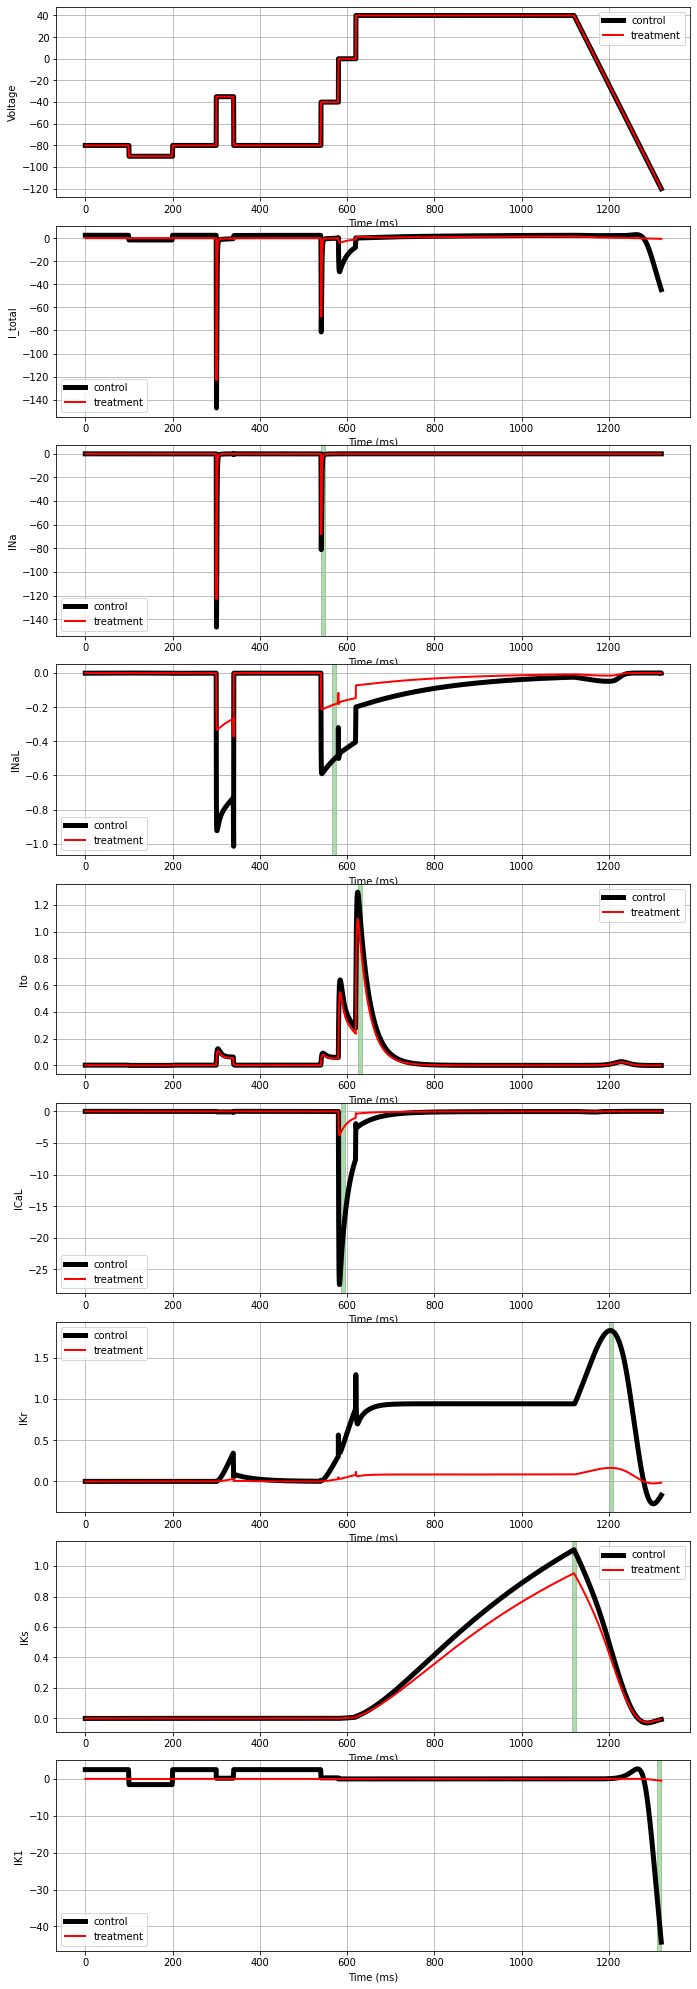

In [14]:
'''
Plot
'''
# current_name = 'IKr'
fig, ax = plt.subplots(len(sol1),1, figsize=(10,30))    
# fig.suptitle(sim.name, fontsize=14)
for i, (name, values) in enumerate(sol1.items()):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax[i].set_xlabel('Time (ms)')       
    ax[i].set_ylabel(f'{name}')      
    ax[i].plot( times1, values, label='control', color='k', linewidth=5)     
    ax[i].plot( times2, sol2[name], label='treatment', color='r', linewidth=2)    
    ax[i].legend()
    ax[i].grid()
    
    if i!=0 and i!=1:
        contribution = max_contributions1[max_contributions1["Current"]==name]['Contribution'].values[0]
        start = max_contributions1[max_contributions1["Current"]==name]['Time Start'].values[0]
        end = max_contributions1[max_contributions1["Current"]==name]['Time End'].values[0]         
        ax[i].axvspan(start, end, color='g', alpha=0.3)  
    
# ax[-1].set_ylim(-5, 5)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
# fig.savefig(os.path.join('Results', "C.jpg"), dpi=100)